In [1]:
import numpy as np
import fiona
from shapely.geometry import shape
import rasterio
from rasterio.windows import get_data_window
import matplotlib.pyplot as plt

%matplotlib inline

### start with a 1 degree x 1 degree DEM tile downloaded from the national map
* this tile covers the La Crosse, WI area, from 43 to 44 deg. N, and 91 to 92 degrees W
* can be downloaded from https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/13/ArcGrid/n44w092.zip
* unzip and copy to the path below to run this script

In [2]:
original_tile = 'data/grdn44w092_13/grdn44w092_13'

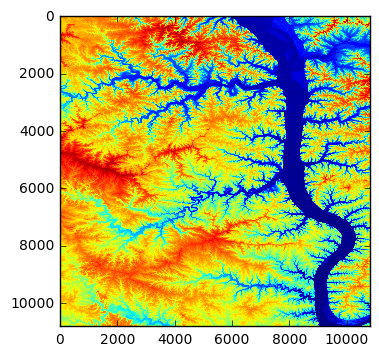

In [3]:
with rasterio.open(original_tile) as src:
    plt.imshow(src.read(1))

In [4]:
src.width, src.height # height and width in pixels

(10812, 10812)

In [5]:
src.bounds # bounding box in lat, lon

BoundingBox(left=-92.00055555556, bottom=42.99944444444, right=-90.99944444444448, top=44.000555555555515)

In [6]:
src.res # x, y resolution in degrees

(9.2592592593e-05, 9.2592592593e-05)

## Clip the raster using a window
#### read only the upper right quarter of the orignal tile and then write it back out
* use a window (https://mapbox.github.io/rasterio/topics/windowed-rw.html)
* the format for specifying the window is ((row_start, row_stop), (col_start, col_stop))

In [7]:
window = ((src.height/2, src.height), (src.width/2, src.width))
window

((5406.0, 10812), (5406.0, 10812))

In [8]:
with rasterio.open(original_tile) as src:
    # read in the upper right quarter
    img = src.read(1, window=window)
    
    # make a fresh copy of the meta data for the source raster
    kwargs = src.meta.copy()
    del kwargs['transform']
    
    # update the meta data with the new dimensions
    kwargs.update({
        'height': int(src.height/2),
        'width': int(src.width/2),
        'affine': src.window_transform(window), # set a new affine transform as well
        'driver': 'GTiff' # also switch the driver to a GeoTiff
    })
    
    # write it out!
    with rasterio.open('data/lc.tif', 'w', **kwargs) as dst:
         # since img is a 2-D array, specify that it should be written to band 1
        dst.write(img, 1)

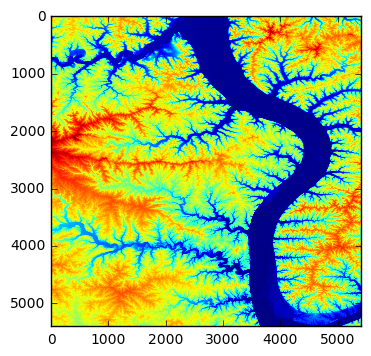

In [9]:
plt.imshow(img)

### reopen the file and verify that it was written correctly

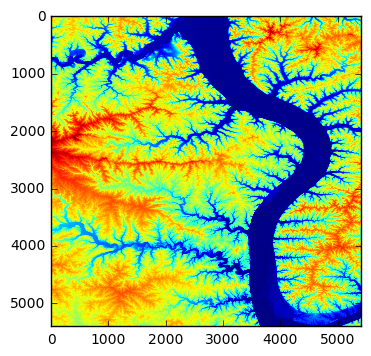

In [10]:
with rasterio.open('data/lc.tif') as src:
    plt.imshow(src.read(1))

## Clip the raster with an arbitrary polygon
* shapefile of counties
* this is also called masking (https://mapbox.github.io/rasterio/topics/masking-by-shapefile.html)
* [more info on Masks](https://github.com/mapbox/rasterio/blob/master/docs/topics/masks.rst) (this also bleeds into Mosaicing)

In [11]:
counties = []
with fiona.open('data/counties.shp') as src:
    for record in src:
        counties.append(record['geometry'])
counties[0] # GeoJSON representation of Allamakee County in MN

{'coordinates': [[(-91.24676227499992, 43.50080723900004),
   (-91.22238443499992, 43.50058482400004),
   (-91.21935417399993, 43.500557177000076),
   (-91.2177261089999, 43.50054232200006),
   (-91.2177083059999, 43.500542160000066),
   (-91.21769915599992, 43.500542077000034),
   (-91.21826315699991, 43.497220077000065),
   (-91.21783698899992, 43.49317721500006),
   (-91.2155900919999, 43.48582113200007),
   (-91.21527515899993, 43.48479007900005),
   (-91.21602815999995, 43.48113408000006),
   (-91.21705602599991, 43.47881737700004),
   (-91.21809114599995, 43.47648432500006),
   (-91.2203921599999, 43.47129808200003),
   (-91.22457915899992, 43.465517083000066),
   (-91.22765463099995, 43.46357948000008),
   (-91.22799348899991, 43.46336599400007),
   (-91.23095679199992, 43.46102094500009),
   (-91.23223415699994, 43.46001008400009),
   (-91.23318015699994, 43.457776085000035),
   (-91.23308728599994, 43.45707959500004),
   (-91.23237633299993, 43.451747846000046),
   (-91.232269

In [12]:
from rasterio.tools.mask import mask

with rasterio.open('data/lc.tif') as src:
    out_image, out_transform = mask(src, [counties[0]], nodata=0, crop=True)
    out_meta = src.meta.copy()
    
    # also write this out as a GeoTiff
    # update the metadata to reflect the new shape of the masked image
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open("data/Allamakee.tif", "w", **out_meta) as dest:
        dest.write(out_image)

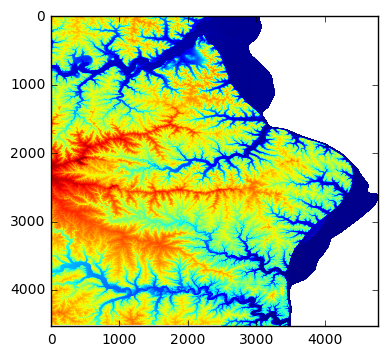

In [13]:
# above we set no data values to zero. 
#Mask them in the plot by converting them to nans
out_image[out_image == 0] = np.nan
plt.imshow(out_image[0, :, :])

### Clip another county, but this time use a buffer so that there's overap
(we will use the results in the Mosaic or Merge example to demonstrate handling of overlap)

#### convert the second county from GeoJSON to a shapely Polygon

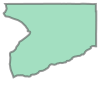

In [14]:
crwfd = shape(counties[1])
crwfd_buff = crwfd.buffer(.01)
crwfd

#### inspect the buffer
* use some fancy unzipping/zipping to convert the coordinate sequence into lists of x and y locations, so we can make a plot with minimal code

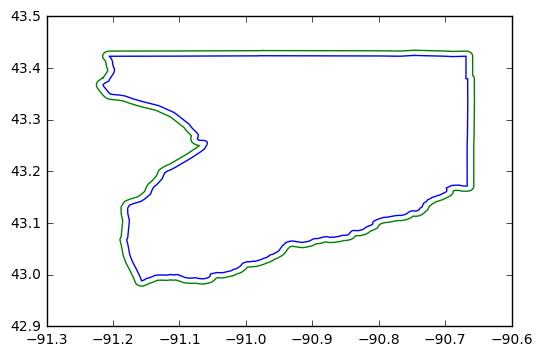

In [15]:
plt.plot(*zip(*crwfd.exterior.coords))
plt.plot(*zip(*crwfd_buff.exterior.coords))

#### go from Polygon back to GeoJSON

In [16]:
crwfd_buff.__geo_interface__

{'coordinates': (((-91.21474244349147, 43.38133349092303),
   (-91.21438435270834, 43.38211646971045),
   (-91.21365386070833, 43.38350945371046),
   (-91.2136195036186, 43.383574388620445),
   (-91.21337036368715, 43.38404110787201),
   (-91.2115620050515, 43.387428756569406),
   (-91.21090072143342, 43.388667556600744),
   (-91.20838628547374, 43.39337791856769),
   (-91.20777542342091, 43.39599610376547),
   (-91.2078189796234, 43.39644422346564),
   (-91.20894378267562, 43.40003433855832),
   (-91.20919712028449, 43.40101425608387),
   (-91.20958459728449, 43.40290282108387),
   (-91.21028311887981, 43.40630741348968),
   (-91.21031611299304, 43.40646822441973),
   (-91.21045131893757, 43.407306620681254),
   (-91.21051490255611, 43.40815346544993),
   (-91.21059956411267, 43.41076007471979),
   (-91.21158213890385, 43.41404263133158),
   (-91.21380884742301, 43.41731271846046),
   (-91.2143226308064, 43.418153496452184),
   (-91.21475117605381, 43.41904075626043),
   (-91.21509032

In [17]:
with rasterio.open('data/lc.tif') as src:
    out_image, out_transform = mask(src, [crwfd_buff.__geo_interface__], nodata=0, crop=True)
    out_meta = src.meta.copy()
    
    # also write this out as a GeoTiff
    # update the metadata to reflect the new shape of the masked image
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
    with rasterio.open("data/Crawford.tif", "w", **out_meta) as dest:
        dest.write(out_image)

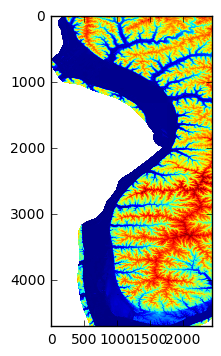

In [18]:
out_image[out_image == 0] = np.nan
plt.imshow(out_image[0, :, :])